# Import libraries

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import LabelEncoder, label_binarize
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch.optim as optim
import torchvision.models as models
import time
import copy
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, f1_score, roc_auc_score
import seaborn as sns
from itertools import cycle
from collections import Counter

# Set Seeds for Reproducibility

In [2]:
import random

# Set seeds for reproducibility
SEED = 42

# Python random
random.seed(SEED)

# Numpy
np.random.seed(SEED)

# PyTorch
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # if using multi-GPU

# PyTorch backend
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print(f"Seeds set to {SEED} for reproducibility")

Seeds set to 42 for reproducibility


# Data Transformation

In [3]:
# ImageNet normalization constants
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

# Training transformations with data augmentation
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(
        size=224,
        scale=(0.9, 1.0),
        ratio=(0.95, 1.05)
    ),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(
        brightness=0.1,
        contrast=0.1,
        saturation=0.05,
        hue=0.02
    ),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=IMAGENET_MEAN,
        std=IMAGENET_STD
    )
])

# Validation and test transformations without augmentation
val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=IMAGENET_MEAN,
        std=IMAGENET_STD
    )
])

# Dataset

In [4]:
BATCH_SIZE = 16
NUM_WORKERS = 4

class BladderTissueDataset(Dataset):
    def __init__(self, dataframe, transform=None, label_encoder=None, fit_label_encoder=False):
        """
        Args:
            dataframe (DataFrame): DataFrame with HLY (image paths) and tissue type (labels) columns.
            transform (callable, optional): Optional transform to be applied on a sample.
            label_encoder (LabelEncoder, optional): Pre-fitted label encoder. If None, creates new one.
            fit_label_encoder (bool): Whether to fit the label encoder on this dataset's labels.
        """
        self.data = dataframe.reset_index(drop=True)
        self.transform = transform
        
        # Handle tissue type label encoding
        if label_encoder is None:
            self.label_encoder = LabelEncoder()
            if fit_label_encoder:
                self.labels = self.label_encoder.fit_transform(self.data['tissue type'])
            else:
                raise ValueError("Must provide label_encoder or set fit_label_encoder=True")
        else:
            self.label_encoder = label_encoder
            self.labels = self.label_encoder.transform(self.data['tissue type'])
        
        self.image_paths = self.data['HLY'].tolist()
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        # Load image
        img_path = self.image_paths[idx]
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading image: {img_path}")
            image = Image.new('RGB', (224, 224), color='black')
        
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(label, dtype=torch.long)
    
    def get_label_encoder(self):
        """Return the label encoder for use with other datasets"""
        return self.label_encoder
    
    def get_class_names(self):
        """Return the original class names"""
        return self.label_encoder.classes_

In [5]:
# Create datasets from DataFrames
def create_datasets_from_dataframes(train_df, val_df, test_df):
    """
    Create train, validation, and test datasets with proper label encoding
    """
    # Create training dataset and fit label encoder
    train_dataset = BladderTissueDataset(
        dataframe=train_df, 
        transform=train_transform,
        fit_label_encoder=True
    )
    
    # Get the fitted encoder
    le = train_dataset.get_label_encoder()
    
    # Create validation dataset using the same encoder
    val_dataset = BladderTissueDataset(
        dataframe=val_df,
        transform=val_test_transform,
        label_encoder=le
    )
    
    # Create test dataset using the same encoder
    test_dataset = BladderTissueDataset(
        dataframe=test_df,
        transform=val_test_transform,
        label_encoder=le
    )
    
    return train_dataset, val_dataset, test_dataset, le

# Dataloader

In [6]:
# Create dataloaders
def create_dataloaders(train_dataset, val_dataset, test_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS):
    """
    Create dataloaders for training, validation, and testing
    """
    # Worker seed for reproducibility
    def seed_worker(worker_id):
        worker_seed = torch.initial_seed() % 2**32
        np.random.seed(worker_seed)
        random.seed(worker_seed)
    
    g = torch.Generator()
    g.manual_seed(42)
    
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
        drop_last=True,
        worker_init_fn=seed_worker,
        generator=g
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
        worker_init_fn=seed_worker,    
        generator=g    
    )

    test_loader = DataLoader(
        test_dataset,
        pin_memory=True,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=False,
        worker_init_fn=seed_worker,
        generator=g
    )
    return train_loader, val_loader, test_loader

In [7]:
train_df = pd.read_csv("/kaggle/input/ebt-dataset/train.csv")
test_df = pd.read_csv("/kaggle/input/ebt-dataset/test.csv")
valid_df = pd.read_csv("/kaggle/input/ebt-dataset/valid.csv")

In [8]:
train_dataset, val_dataset, test_dataset, label_encoder = create_datasets_from_dataframes(
    train_df, valid_df, test_df
)

train_loader, val_loader, test_loader = create_dataloaders(
    train_dataset, val_dataset, test_dataset, 
    batch_size=32, 
    num_workers=4
)

print(f"Tissue Types: {label_encoder.classes_}")
# Print encoding information

Tissue Types: ['HGC' 'LGC' 'NST' 'NTL']


# Utility Functions

In [9]:
def compute_class_weights(train_loader, num_classes):
    """Compute class weights for handling imbalanced datasets"""
    class_counts = Counter()

    for _, labels in train_loader:
        class_counts.update(labels.numpy())

    total_samples = sum(class_counts.values())

    weights = []
    for i in range(num_classes):
        weights.append(total_samples / (num_classes * class_counts[i]))

    return torch.tensor(weights, dtype=torch.float)

# Model Training Framework

In [10]:
class ModelTrainer:
    def __init__(self, model, train_loader, val_loader, test_loader, device='cuda'):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.device = device
        
        # Training history
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []
        
    def train_model(self, num_epochs=25, lr=0.001, weight_decay=1e-4, save_best=True, model_name="model"):
        """Train the model with early stopping and best model saving based on macro-F1"""
        
        # Loss function and optimizer
        class_weights = compute_class_weights(self.train_loader, num_classes=len(self.train_loader.dataset.get_label_encoder().classes_))
        class_weights = class_weights.to(self.device)
        criterion = nn.CrossEntropyLoss(weight=class_weights)
        optimizer = optim.Adam(self.model.parameters(), lr=lr, weight_decay=weight_decay)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
        
        # Best model tracking
        best_val_f1 = 0.0
        best_model_wts = copy.deepcopy(self.model.state_dict())
        patience = 5
        patience_counter = 0
        
        print(f"Starting training for {num_epochs} epochs...")
        print("-" * 60)
        
        start_time = time.time()
        
        for epoch in range(num_epochs):
            print(f'Epoch {epoch+1}/{num_epochs}')
            print('-' * 10)
            
            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    self.model.train()
                    dataloader = self.train_loader
                else:
                    self.model.eval()
                    dataloader = self.val_loader
                
                running_loss = 0.0
                running_corrects = 0
                total_samples = 0
                all_preds = []
                all_labels = []
                
                # Progress bar
                pbar = tqdm(dataloader, desc=f'{phase.capitalize()} ')
                
                for inputs, labels in pbar:
                    inputs = inputs.to(self.device)
                    labels = labels.to(self.device)
                    
                    # Zero gradients
                    optimizer.zero_grad()
                    
                    # Forward pass
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = self.model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        
                        # Backward pass (only in training)
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                    
                    # Statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                    total_samples += inputs.size(0)
                    
                    # Store predictions and labels for F1 calculation
                    all_preds.extend(preds.cpu().numpy())
                    all_labels.extend(labels.cpu().numpy())
                    
                    # Update progress bar
                    current_acc = running_corrects.double() / total_samples
                    pbar.set_postfix({
                        'Loss': f'{running_loss/total_samples:.4f}',
                        'Acc': f'{current_acc:.4f}'
                    })
                
                # Calculate epoch metrics
                epoch_loss = running_loss / total_samples
                epoch_acc = running_corrects.double() / total_samples
                epoch_f1 = f1_score(all_labels, all_preds, average='macro')
                
                print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} Macro-F1: {epoch_f1:.4f}')
                
                # Store metrics
                if phase == 'train':
                    self.train_losses.append(epoch_loss)
                    self.train_accuracies.append(epoch_acc.cpu())
                else:
                    self.val_losses.append(epoch_loss)
                    self.val_accuracies.append(epoch_acc.cpu())
                
                # Save best model based on validation macro-F1
                if phase == 'val' and epoch_f1 > best_val_f1:
                    best_val_f1 = epoch_f1
                    best_model_wts = copy.deepcopy(self.model.state_dict())
                    patience_counter = 0
                    if save_best:
                        torch.save(self.model.state_dict(), f'best_{model_name}.pth')
                        print(f'✓ New best model saved with validation macro-F1: {best_val_f1:.4f}')
                elif phase == 'val':
                    patience_counter += 1
            
            # Learning rate scheduler step (after both train and val phases)
            scheduler.step()
            
            # Early stopping
            if patience_counter >= patience:
                print(f'Early stopping triggered after {epoch+1} epochs')
                break
                
            print()
        
        # Training complete
        time_elapsed = time.time() - start_time
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best validation macro-F1: {best_val_f1:.4f}')
        
        # Load best model weights
        self.model.load_state_dict(best_model_wts)
        return self.model
    
    def evaluate_model(self, test_loader=None, class_names=['HGC', 'LGC', 'NST', 'NTL']):
        """Evaluate model on test set and return all metrics"""
        if test_loader is None:
            test_loader = self.test_loader
            
        self.model.eval()
        all_preds = []
        all_labels = []
        all_probs = []
        test_loss = 0.0
        correct = 0
        total = 0
        
        criterion = nn.CrossEntropyLoss()
        
        print("Evaluating on test set...")
        with torch.no_grad():
            for inputs, labels in tqdm(test_loader):
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)
                
                outputs = self.model(inputs)
                probs = torch.softmax(outputs, dim=1)
                loss = criterion(outputs, labels)
                
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                test_loss += loss.item() * inputs.size(0)
                
                # Store for detailed metrics
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                all_probs.extend(probs.cpu().numpy())
        
        # Calculate metrics
        test_acc = 100 * correct / total
        avg_test_loss = test_loss / total
        
        print(f'Test Accuracy: {test_acc:.2f}%')
        print(f'Test Loss: {avg_test_loss:.4f}')
        
        # Detailed classification report
        print("\nClassification Report:")
        report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
        print(classification_report(all_labels, all_preds, target_names=class_names))
        
        # Confusion Matrix
        cm = confusion_matrix(all_labels, all_preds)
        print(f"\nConfusion Matrix:")
        print(cm)
        
        # Compute ROC-AUC scores
        labels_bin = label_binarize(all_labels, classes=list(range(len(class_names))))
        probs_array = np.array(all_probs)
        
        # Per-class ROC-AUC
        per_class_auc = {}
        for i, class_name in enumerate(class_names):
            try:
                per_class_auc[class_name] = roc_auc_score(labels_bin[:, i], probs_array[:, i])
            except:
                per_class_auc[class_name] = 0.0
        
        # Macro ROC-AUC (average of per-class AUCs)
        macro_auc = np.mean(list(per_class_auc.values()))
        
        # Micro ROC-AUC (using all predictions)
        try:
            micro_auc = roc_auc_score(labels_bin.ravel(), probs_array.ravel())
        except:
            micro_auc = 0.0
        
        print(f"\nROC-AUC Scores:")
        print(f"Macro-average AUC: {macro_auc:.4f}")
        print(f"Micro-average AUC: {micro_auc:.4f}")
        for class_name, auc_score in per_class_auc.items():
            print(f"{class_name} AUC: {auc_score:.4f}")
        
        return {
            'accuracy': test_acc,
            'loss': avg_test_loss,
            'predictions': all_preds,
            'labels': all_labels,
            'probabilities': all_probs,
            'confusion_matrix': cm,
            'classification_report': report,
            'per_class_auc': per_class_auc,
            'macro_auc': macro_auc,
            'micro_auc': micro_auc
        }
    
    def plot_training_history(self, save_path=None):
        """Plot training and validation metrics"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Plot losses
        ax1.plot(self.train_losses, label='Train Loss', marker='o')
        ax1.plot(self.val_losses, label='Validation Loss', marker='s')
        ax1.set_title('Model Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True)
        
        # Plot accuracies
        ax2.plot(self.train_accuracies, label='Train Accuracy', marker='o')
        ax2.plot(self.val_accuracies, label='Validation Accuracy', marker='s')
        ax2.set_title('Model Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.legend()
        ax2.grid(True)
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path)
        ax2.set_xlabel('Epoch')

# Model Definitions

In [11]:
def create_resnet_model(model_type='resnet50', num_classes=4, pretrained=True):
    """
    Create ResNet model for bladder tissue classification
    
    Args:
        model_type (str): ResNet architecture - 'resnet50' or 'resnet101'
        num_classes (int): Number of output classes
        pretrained (bool): Whether to use pretrained weights
    
    Returns:
        model: ResNet model
    """
    if model_type == 'resnet50':
        model = models.resnet50(pretrained=pretrained)
    elif model_type == 'resnet101':
        model = models.resnet101(pretrained=pretrained)
    else:
        raise ValueError(f"Unsupported model type: {model_type}")
    
    # Replace the final fc layer for our number of classes
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, num_classes)
    
    return model

# Configure GPU

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


# Visualization Functions

In [13]:
def plot_confusion_matrix(cm, class_names, model_name, save_path=None):
    """Plot confusion matrix with nice formatting"""
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count'})
    plt.title(f'Confusion Matrix - {model_name}', fontsize=16, pad=20)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def plot_roc_curves(labels, probs, class_names, model_name, save_path=None):
    """Plot ROC curves for multi-class classification"""
    # Binarize the labels
    n_classes = len(class_names)
    labels_bin = label_binarize(labels, classes=list(range(n_classes)))
    probs_array = np.array(probs)
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(labels_bin[:, i], probs_array[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(labels_bin.ravel(), probs_array.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # Plot ROC curves
    plt.figure(figsize=(12, 8))
    colors = cycle(['blue', 'red', 'green', 'orange', 'purple'])
    
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'{class_names[i]} (AUC = {roc_auc[i]:.3f})')
    
    plt.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle=':', linewidth=3,
             label=f'Micro-average (AUC = {roc_auc["micro"]:.3f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(f'ROC Curves - {model_name}', fontsize=16, pad=20)
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    return roc_auc

# Train and Evaluate Models

In [14]:
# Get class names from label encoder
class_names = list(label_encoder.classes_)
print(f"Classes: {class_names}")

# Store results for all models
all_results = []

Classes: ['HGC', 'LGC', 'NST', 'NTL']


## Train ResNet-50

Training ResNet-50


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 247MB/s]


Starting training for 25 epochs...
------------------------------------------------------------
Epoch 1/25
----------


Train : 100%|██████████| 38/38 [00:08<00:00,  4.26it/s, Loss=1.0719, Acc=0.6143]


Train Loss: 1.0719 Acc: 0.6143 Macro-F1: 0.5606


Val : 100%|██████████| 10/10 [00:01<00:00,  6.72it/s, Loss=0.8802, Acc=0.6546]


Val Loss: 0.8802 Acc: 0.6546 Macro-F1: 0.6148
✓ New best model saved with validation macro-F1: 0.6148

Epoch 2/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  4.91it/s, Loss=0.6491, Acc=0.7632]


Train Loss: 0.6491 Acc: 0.7632 Macro-F1: 0.7188


Val : 100%|██████████| 10/10 [00:01<00:00,  9.65it/s, Loss=1.7333, Acc=0.6678]


Val Loss: 1.7333 Acc: 0.6678 Macro-F1: 0.6041

Epoch 3/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  4.94it/s, Loss=0.6475, Acc=0.7730]


Train Loss: 0.6475 Acc: 0.7730 Macro-F1: 0.7224


Val : 100%|██████████| 10/10 [00:01<00:00,  9.02it/s, Loss=0.5002, Acc=0.8355]


Val Loss: 0.5002 Acc: 0.8355 Macro-F1: 0.8121
✓ New best model saved with validation macro-F1: 0.8121

Epoch 4/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  4.93it/s, Loss=0.4266, Acc=0.8512]


Train Loss: 0.4266 Acc: 0.8512 Macro-F1: 0.8152


Val : 100%|██████████| 10/10 [00:01<00:00,  9.41it/s, Loss=0.9062, Acc=0.6974]


Val Loss: 0.9062 Acc: 0.6974 Macro-F1: 0.6703

Epoch 5/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  4.93it/s, Loss=0.3706, Acc=0.8635]


Train Loss: 0.3706 Acc: 0.8635 Macro-F1: 0.8359


Val : 100%|██████████| 10/10 [00:01<00:00,  9.60it/s, Loss=0.6639, Acc=0.7072]


Val Loss: 0.6639 Acc: 0.7072 Macro-F1: 0.6773

Epoch 6/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  4.94it/s, Loss=0.3516, Acc=0.8766]


Train Loss: 0.3516 Acc: 0.8766 Macro-F1: 0.8485


Val : 100%|██████████| 10/10 [00:01<00:00,  9.90it/s, Loss=0.2520, Acc=0.8816]


Val Loss: 0.2520 Acc: 0.8816 Macro-F1: 0.8486
✓ New best model saved with validation macro-F1: 0.8486

Epoch 7/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  4.96it/s, Loss=0.3391, Acc=0.8923]


Train Loss: 0.3391 Acc: 0.8923 Macro-F1: 0.8552


Val : 100%|██████████| 10/10 [00:01<00:00,  9.71it/s, Loss=1.5909, Acc=0.5658]


Val Loss: 1.5909 Acc: 0.5658 Macro-F1: 0.5341

Epoch 8/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  4.94it/s, Loss=0.2614, Acc=0.9054]


Train Loss: 0.2614 Acc: 0.9054 Macro-F1: 0.8909


Val : 100%|██████████| 10/10 [00:01<00:00,  8.86it/s, Loss=0.1023, Acc=0.9803]


Val Loss: 0.1023 Acc: 0.9803 Macro-F1: 0.9762
✓ New best model saved with validation macro-F1: 0.9762

Epoch 9/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  4.96it/s, Loss=0.1400, Acc=0.9613]


Train Loss: 0.1400 Acc: 0.9613 Macro-F1: 0.9489


Val : 100%|██████████| 10/10 [00:01<00:00,  9.56it/s, Loss=0.0850, Acc=0.9704]


Val Loss: 0.0850 Acc: 0.9704 Macro-F1: 0.9640

Epoch 10/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  4.87it/s, Loss=0.1244, Acc=0.9589]


Train Loss: 0.1244 Acc: 0.9589 Macro-F1: 0.9527


Val : 100%|██████████| 10/10 [00:01<00:00,  9.56it/s, Loss=0.0804, Acc=0.9737]


Val Loss: 0.0804 Acc: 0.9737 Macro-F1: 0.9628

Epoch 11/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  4.92it/s, Loss=0.0858, Acc=0.9737]


Train Loss: 0.0858 Acc: 0.9737 Macro-F1: 0.9719


Val : 100%|██████████| 10/10 [00:01<00:00,  9.23it/s, Loss=0.0699, Acc=0.9704]


Val Loss: 0.0699 Acc: 0.9704 Macro-F1: 0.9566

Epoch 12/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  4.95it/s, Loss=0.0862, Acc=0.9729]


Train Loss: 0.0862 Acc: 0.9729 Macro-F1: 0.9705


Val : 100%|██████████| 10/10 [00:01<00:00,  9.63it/s, Loss=0.0620, Acc=0.9770]


Val Loss: 0.0620 Acc: 0.9770 Macro-F1: 0.9692

Epoch 13/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  4.92it/s, Loss=0.0586, Acc=0.9836]


Train Loss: 0.0586 Acc: 0.9836 Macro-F1: 0.9832


Val : 100%|██████████| 10/10 [00:01<00:00,  9.52it/s, Loss=0.0392, Acc=0.9836]


Val Loss: 0.0392 Acc: 0.9836 Macro-F1: 0.9744
Early stopping triggered after 13 epochs
Training complete in 1m 57s
Best validation macro-F1: 0.9762
Evaluating on test set...


100%|██████████| 6/6 [00:01<00:00,  5.58it/s]


Test Accuracy: 67.20%
Test Loss: 1.0859

Classification Report:
              precision    recall  f1-score   support

         HGC       0.72      0.80      0.76        74
         LGC       0.81      0.40      0.53        53
         NST       0.89      0.65      0.75        37
         NTL       0.43      0.92      0.58        25

    accuracy                           0.67       189
   macro avg       0.71      0.69      0.66       189
weighted avg       0.74      0.67      0.67       189


Confusion Matrix:
[[59  5  2  8]
 [17 21  1 14]
 [ 4  0 24  9]
 [ 2  0  0 23]]

ROC-AUC Scores:
Macro-average AUC: 0.8594
Micro-average AUC: 0.8443
HGC AUC: 0.8826
LGC AUC: 0.8063
NST AUC: 0.8398
NTL AUC: 0.9090


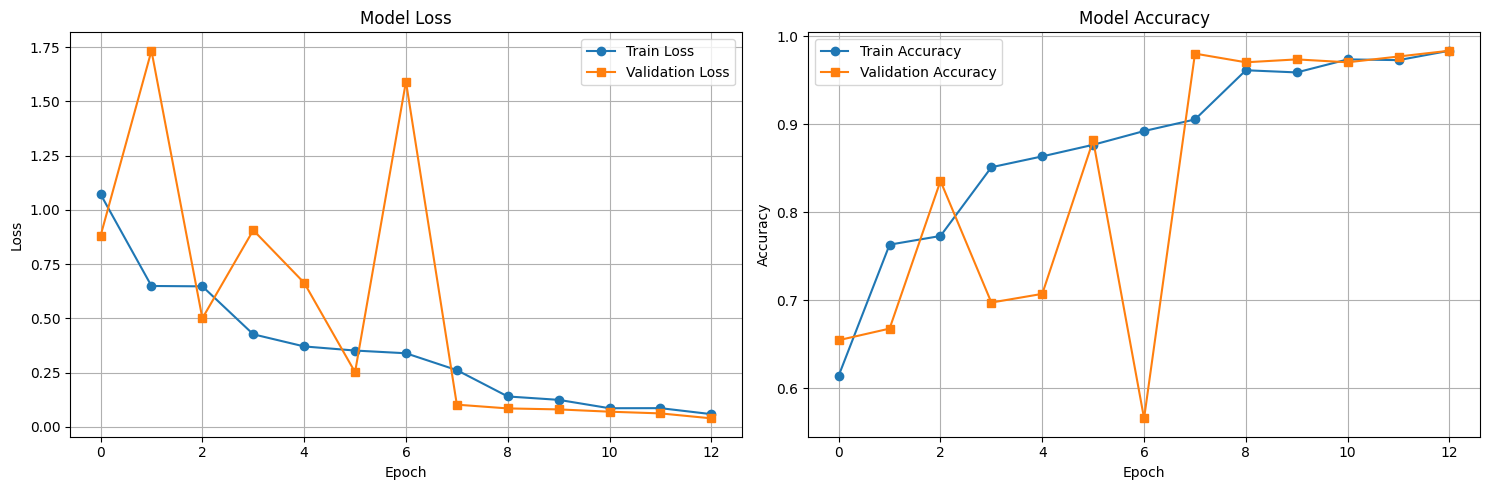

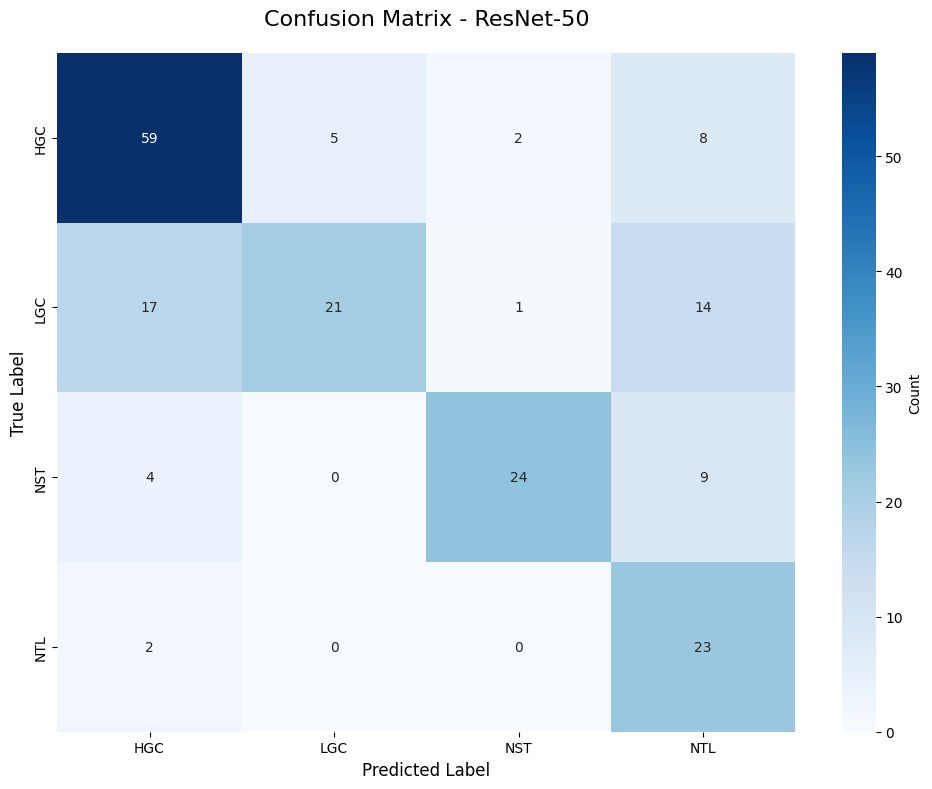

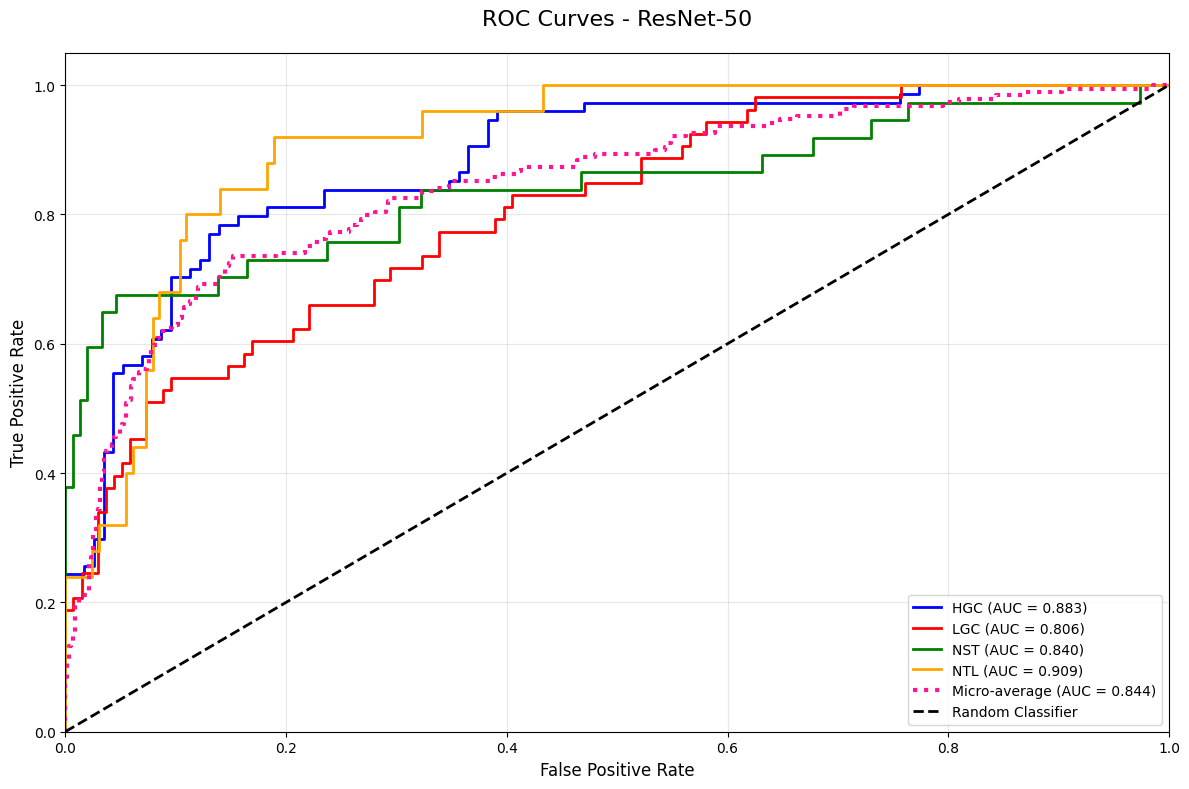


ResNet-50 training and evaluation complete!


In [15]:
print("=" * 80)
print("Training ResNet-50")
print("=" * 80)

# Create model
resnet50 = create_resnet_model(model_type='resnet50', num_classes=4, pretrained=True)

# Create trainer
trainer_50 = ModelTrainer(resnet50, train_loader, val_loader, test_loader, device=device)

# Train model
trained_model_50 = trainer_50.train_model(num_epochs=25, lr=0.001, save_best=True, model_name="resnet50")

# Plot training history
trainer_50.plot_training_history(save_path='resnet50_training_history.png')

# Evaluate model
results_50 = trainer_50.evaluate_model(class_names=class_names)

# Plot confusion matrix
plot_confusion_matrix(results_50['confusion_matrix'], class_names, 'ResNet-50',
                      save_path='resnet50_confusion_matrix.png')

# Plot ROC curves
roc_auc_50 = plot_roc_curves(results_50['labels'], results_50['probabilities'], class_names, 'ResNet-50',
                              save_path='resnet50_roc_curves.png')
# Store results
results_50['model_name'] = 'ResNet-50'
results_50['roc_auc'] = roc_auc_50
all_results.append(results_50)

print("\nResNet-50 training and evaluation complete!")

## Train ResNet-101

Training ResNet-101


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


100%|██████████| 171M/171M [00:00<00:00, 225MB/s]


Starting training for 25 epochs...
------------------------------------------------------------
Epoch 1/25
----------


Train : 100%|██████████| 38/38 [00:11<00:00,  3.30it/s, Loss=1.1090, Acc=0.5929]


Train Loss: 1.1090 Acc: 0.5929 Macro-F1: 0.5373


Val : 100%|██████████| 10/10 [00:01<00:00,  7.75it/s, Loss=11.3658, Acc=0.3289]


Val Loss: 11.3658 Acc: 0.3289 Macro-F1: 0.2233
✓ New best model saved with validation macro-F1: 0.2233

Epoch 2/25
----------


Train : 100%|██████████| 38/38 [00:11<00:00,  3.30it/s, Loss=0.8201, Acc=0.7360]


Train Loss: 0.8201 Acc: 0.7360 Macro-F1: 0.6715


Val : 100%|██████████| 10/10 [00:01<00:00,  7.76it/s, Loss=1.0804, Acc=0.5329]


Val Loss: 1.0804 Acc: 0.5329 Macro-F1: 0.4758
✓ New best model saved with validation macro-F1: 0.4758

Epoch 3/25
----------


Train : 100%|██████████| 38/38 [00:11<00:00,  3.30it/s, Loss=0.7413, Acc=0.7344]


Train Loss: 0.7413 Acc: 0.7344 Macro-F1: 0.6820


Val : 100%|██████████| 10/10 [00:01<00:00,  7.69it/s, Loss=1.6765, Acc=0.5493]


Val Loss: 1.6765 Acc: 0.5493 Macro-F1: 0.4542

Epoch 4/25
----------


Train : 100%|██████████| 38/38 [00:11<00:00,  3.30it/s, Loss=0.6867, Acc=0.7722]


Train Loss: 0.6867 Acc: 0.7722 Macro-F1: 0.7167


Val : 100%|██████████| 10/10 [00:01<00:00,  7.86it/s, Loss=0.4699, Acc=0.8487]


Val Loss: 0.4699 Acc: 0.8487 Macro-F1: 0.7965
✓ New best model saved with validation macro-F1: 0.7965

Epoch 5/25
----------


Train : 100%|██████████| 38/38 [00:11<00:00,  3.30it/s, Loss=0.5165, Acc=0.8289]


Train Loss: 0.5165 Acc: 0.8289 Macro-F1: 0.7845


Val : 100%|██████████| 10/10 [00:01<00:00,  7.32it/s, Loss=0.3505, Acc=0.8849]


Val Loss: 0.3505 Acc: 0.8849 Macro-F1: 0.8520
✓ New best model saved with validation macro-F1: 0.8520

Epoch 6/25
----------


Train : 100%|██████████| 38/38 [00:11<00:00,  3.29it/s, Loss=0.3782, Acc=0.8651]


Train Loss: 0.3782 Acc: 0.8651 Macro-F1: 0.8346


Val : 100%|██████████| 10/10 [00:01<00:00,  7.90it/s, Loss=0.5848, Acc=0.8092]


Val Loss: 0.5848 Acc: 0.8092 Macro-F1: 0.7709

Epoch 7/25
----------


Train : 100%|██████████| 38/38 [00:11<00:00,  3.32it/s, Loss=0.4303, Acc=0.8692]


Train Loss: 0.4303 Acc: 0.8692 Macro-F1: 0.8184


Val : 100%|██████████| 10/10 [00:01<00:00,  7.76it/s, Loss=0.6158, Acc=0.7632]


Val Loss: 0.6158 Acc: 0.7632 Macro-F1: 0.7001

Epoch 8/25
----------


Train : 100%|██████████| 38/38 [00:11<00:00,  3.31it/s, Loss=0.2417, Acc=0.9219]


Train Loss: 0.2417 Acc: 0.9219 Macro-F1: 0.9094


Val : 100%|██████████| 10/10 [00:01<00:00,  7.76it/s, Loss=0.1833, Acc=0.9375]


Val Loss: 0.1833 Acc: 0.9375 Macro-F1: 0.9066
✓ New best model saved with validation macro-F1: 0.9066

Epoch 9/25
----------


Train : 100%|██████████| 38/38 [00:11<00:00,  3.31it/s, Loss=0.1773, Acc=0.9383]


Train Loss: 0.1773 Acc: 0.9383 Macro-F1: 0.9269


Val : 100%|██████████| 10/10 [00:01<00:00,  7.82it/s, Loss=0.1542, Acc=0.9474]


Val Loss: 0.1542 Acc: 0.9474 Macro-F1: 0.9192
✓ New best model saved with validation macro-F1: 0.9192

Epoch 10/25
----------


Train : 100%|██████████| 38/38 [00:11<00:00,  3.31it/s, Loss=0.1504, Acc=0.9630]


Train Loss: 0.1504 Acc: 0.9630 Macro-F1: 0.9570


Val : 100%|██████████| 10/10 [00:01<00:00,  7.87it/s, Loss=0.1361, Acc=0.9441]


Val Loss: 0.1361 Acc: 0.9441 Macro-F1: 0.9138

Epoch 11/25
----------


Train : 100%|██████████| 38/38 [00:11<00:00,  3.31it/s, Loss=0.1214, Acc=0.9605]


Train Loss: 0.1214 Acc: 0.9605 Macro-F1: 0.9484


Val : 100%|██████████| 10/10 [00:01<00:00,  7.93it/s, Loss=0.1180, Acc=0.9507]


Val Loss: 0.1180 Acc: 0.9507 Macro-F1: 0.9239
✓ New best model saved with validation macro-F1: 0.9239

Epoch 12/25
----------


Train : 100%|██████████| 38/38 [00:11<00:00,  3.31it/s, Loss=0.1064, Acc=0.9679]


Train Loss: 0.1064 Acc: 0.9679 Macro-F1: 0.9629


Val : 100%|██████████| 10/10 [00:01<00:00,  7.65it/s, Loss=0.1161, Acc=0.9474]


Val Loss: 0.1161 Acc: 0.9474 Macro-F1: 0.9212

Epoch 13/25
----------


Train : 100%|██████████| 38/38 [00:11<00:00,  3.31it/s, Loss=0.0958, Acc=0.9762]


Train Loss: 0.0958 Acc: 0.9762 Macro-F1: 0.9678


Val : 100%|██████████| 10/10 [00:01<00:00,  7.81it/s, Loss=0.0642, Acc=0.9836]


Val Loss: 0.0642 Acc: 0.9836 Macro-F1: 0.9755
✓ New best model saved with validation macro-F1: 0.9755

Epoch 14/25
----------


Train : 100%|██████████| 38/38 [00:11<00:00,  3.30it/s, Loss=0.0962, Acc=0.9655]


Train Loss: 0.0962 Acc: 0.9655 Macro-F1: 0.9546


Val : 100%|██████████| 10/10 [00:01<00:00,  7.86it/s, Loss=0.0805, Acc=0.9868]


Val Loss: 0.0805 Acc: 0.9868 Macro-F1: 0.9780
✓ New best model saved with validation macro-F1: 0.9780

Epoch 15/25
----------


Train : 100%|██████████| 38/38 [00:11<00:00,  3.31it/s, Loss=0.0835, Acc=0.9745]


Train Loss: 0.0835 Acc: 0.9745 Macro-F1: 0.9711


Val : 100%|██████████| 10/10 [00:01<00:00,  7.62it/s, Loss=0.0796, Acc=0.9868]


Val Loss: 0.0796 Acc: 0.9868 Macro-F1: 0.9780

Epoch 16/25
----------


Train : 100%|██████████| 38/38 [00:11<00:00,  3.31it/s, Loss=0.0767, Acc=0.9729]


Train Loss: 0.0767 Acc: 0.9729 Macro-F1: 0.9720


Val : 100%|██████████| 10/10 [00:01<00:00,  7.79it/s, Loss=0.0715, Acc=0.9868]


Val Loss: 0.0715 Acc: 0.9868 Macro-F1: 0.9780

Epoch 17/25
----------


Train : 100%|██████████| 38/38 [00:11<00:00,  3.29it/s, Loss=0.0715, Acc=0.9762]


Train Loss: 0.0715 Acc: 0.9762 Macro-F1: 0.9726


Val : 100%|██████████| 10/10 [00:01<00:00,  7.68it/s, Loss=0.0763, Acc=0.9836]


Val Loss: 0.0763 Acc: 0.9836 Macro-F1: 0.9751

Epoch 18/25
----------


Train : 100%|██████████| 38/38 [00:11<00:00,  3.28it/s, Loss=0.0773, Acc=0.9786]


Train Loss: 0.0773 Acc: 0.9786 Macro-F1: 0.9740


Val : 100%|██████████| 10/10 [00:01<00:00,  7.81it/s, Loss=0.0600, Acc=0.9868]


Val Loss: 0.0600 Acc: 0.9868 Macro-F1: 0.9780

Epoch 19/25
----------


Train : 100%|██████████| 38/38 [00:11<00:00,  3.29it/s, Loss=0.0774, Acc=0.9753]


Train Loss: 0.0774 Acc: 0.9753 Macro-F1: 0.9735


Val : 100%|██████████| 10/10 [00:01<00:00,  7.64it/s, Loss=0.0705, Acc=0.9836]


Val Loss: 0.0705 Acc: 0.9836 Macro-F1: 0.9751
Early stopping triggered after 19 epochs
Training complete in 4m 7s
Best validation macro-F1: 0.9780
Evaluating on test set...


100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


Test Accuracy: 37.04%
Test Loss: 2.3658

Classification Report:
              precision    recall  f1-score   support

         HGC       0.50      0.15      0.23        74
         LGC       0.20      0.23      0.21        53
         NST       0.55      0.73      0.63        37
         NTL       0.34      0.80      0.48        25

    accuracy                           0.37       189
   macro avg       0.40      0.48      0.39       189
weighted avg       0.41      0.37      0.34       189


Confusion Matrix:
[[11 48 11  4]
 [11 12  6 24]
 [ 0  0 27 10]
 [ 0  0  5 20]]

ROC-AUC Scores:
Macro-average AUC: 0.7261
Micro-average AUC: 0.6677
HGC AUC: 0.7286
LGC AUC: 0.4109
NST AUC: 0.8890
NTL AUC: 0.8759


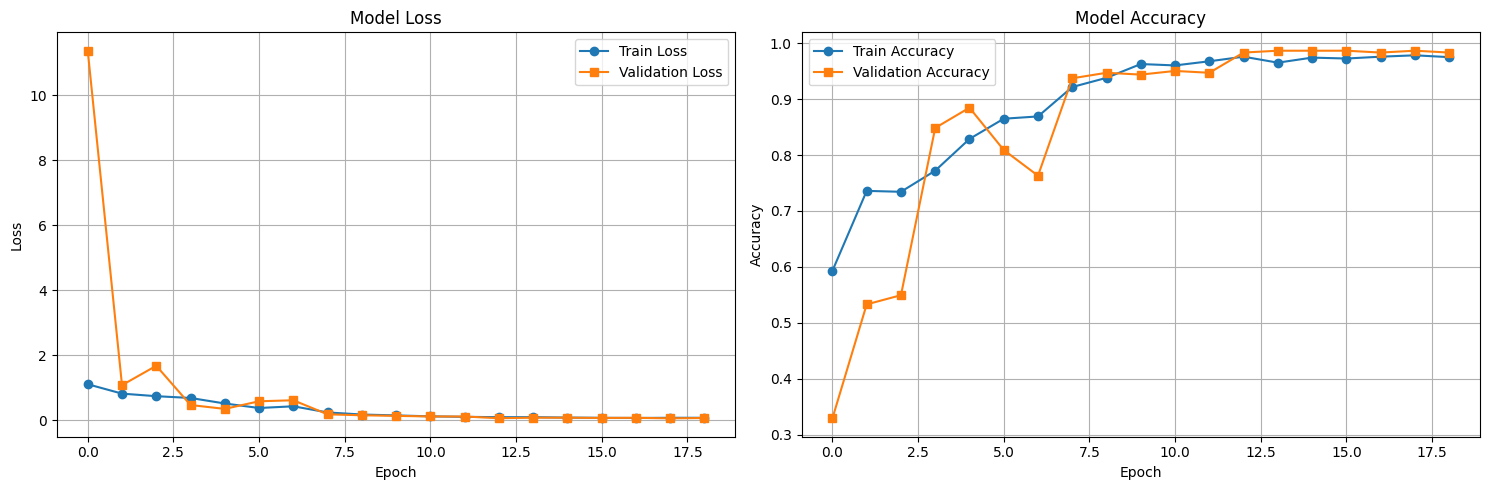

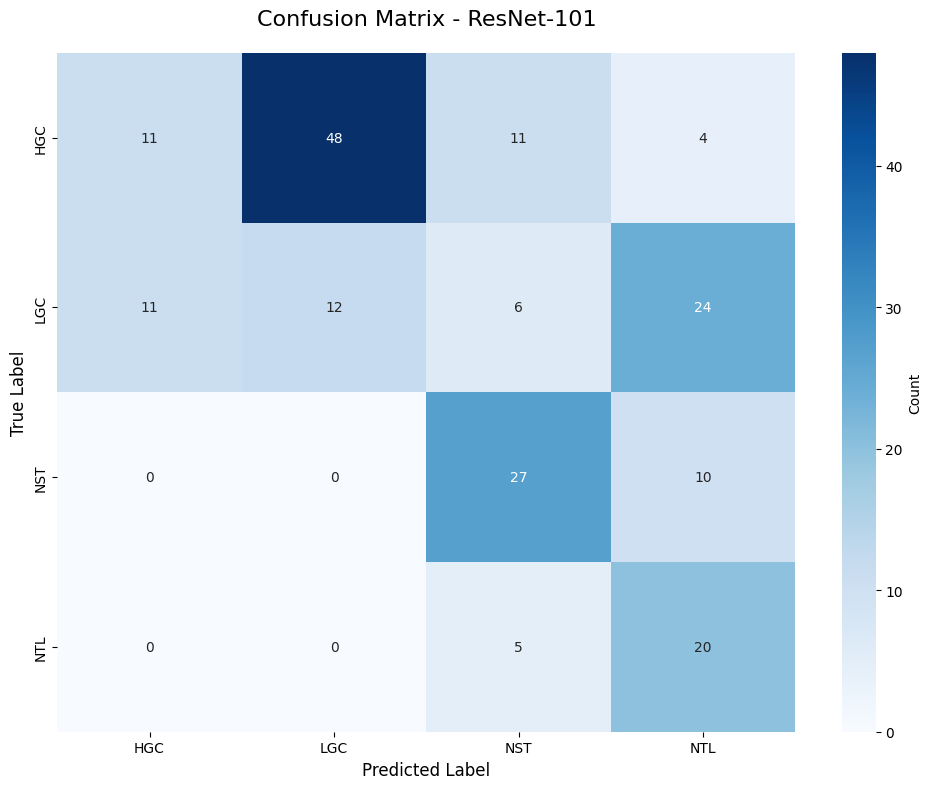

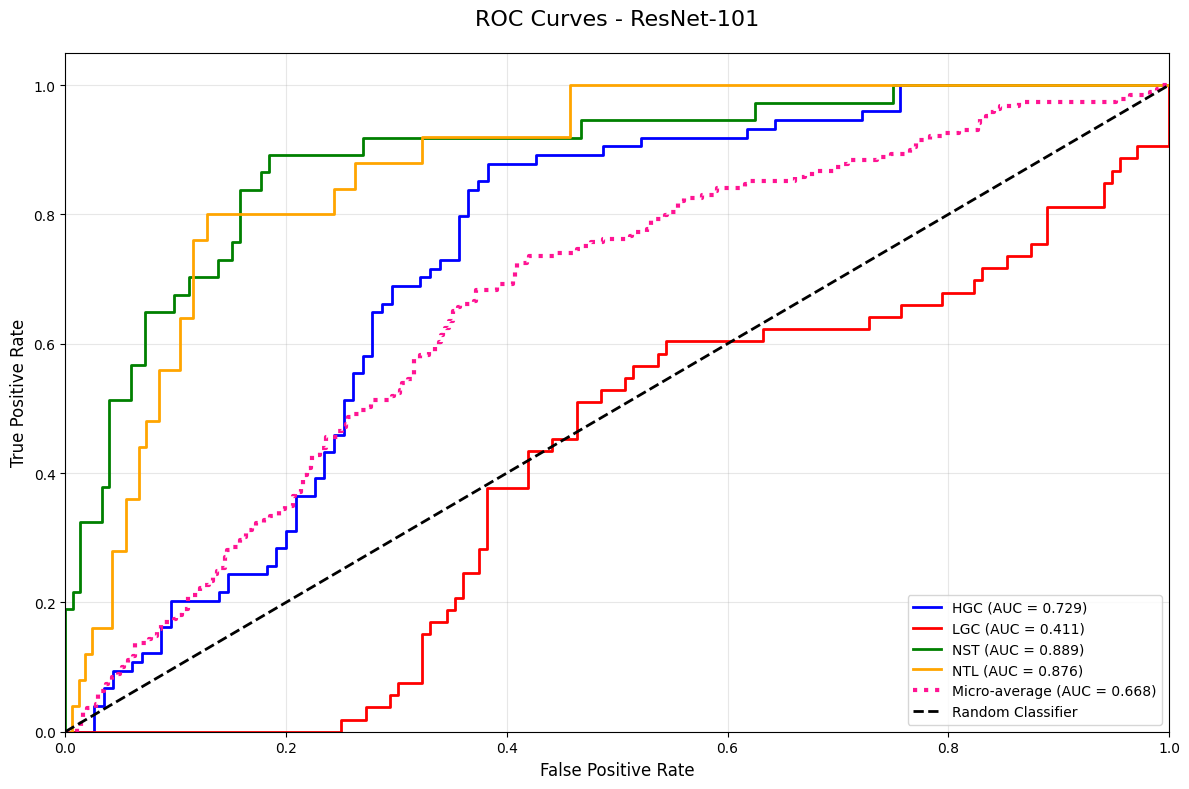


ResNet-101 training and evaluation complete!


In [16]:
print("=" * 80)
print("Training ResNet-101")
print("=" * 80)

# Create model
resnet101 = create_resnet_model(model_type='resnet101', num_classes=4, pretrained=True)

# Create trainer
trainer_101 = ModelTrainer(resnet101, train_loader, val_loader, test_loader, device=device)

# Train model
trained_model_101 = trainer_101.train_model(num_epochs=25, lr=0.001, save_best=True, model_name="resnet101")

# Plot training history
trainer_101.plot_training_history(save_path='resnet101_training_history.png')

# Evaluate model
results_101 = trainer_101.evaluate_model(class_names=class_names)

# Plot confusion matrix
plot_confusion_matrix(results_101['confusion_matrix'], class_names, 'ResNet-101',
                      save_path='resnet101_confusion_matrix.png')

# Plot ROC curves
roc_auc_101 = plot_roc_curves(results_101['labels'], results_101['probabilities'], class_names, 'ResNet-101',
                               save_path='resnet101_roc_curves.png')
# Store results
results_101['model_name'] = 'ResNet-101'
results_101['roc_auc'] = roc_auc_101
all_results.append(results_101)

print("\nResNet-101 training and evaluation complete!")

# Save All Metrics to CSV

In [17]:
# Prepare data for CSV
metrics_data = []

for result in all_results:
    model_name = result['model_name']
    report = result['classification_report']
    
    # Overall metrics
    row = {
        'Model': model_name,
        'Overall_Accuracy': result['accuracy'],
        'Overall_Loss': result['loss'],
        'Macro_Avg_Precision': report['macro avg']['precision'],
        'Macro_Avg_Recall': report['macro avg']['recall'],
        'Macro_Avg_F1': report['macro avg']['f1-score'],
        'Weighted_Avg_Precision': report['weighted avg']['precision'],
        'Weighted_Avg_Recall': report['weighted avg']['recall'],
        'Weighted_Avg_F1': report['weighted avg']['f1-score'],
    }
    
    # Per-class metrics
    for class_name in class_names:
        row[f'{class_name}_Precision'] = report[class_name]['precision']
        row[f'{class_name}_Recall'] = report[class_name]['recall']
        row[f'{class_name}_F1'] = report[class_name]['f1-score']
        row[f'{class_name}_Support'] = report[class_name]['support']
    
    # ROC-AUC scores
    row['Macro_AUC'] = result['macro_auc']
    row['Micro_AUC'] = result['micro_auc']
    for class_name in class_names:
        row[f'{class_name}_AUC'] = result['per_class_auc'][class_name]
    
    # Also store ROC-AUC from plot_roc_curves if available
    if 'roc_auc' in result:
        for i, class_name in enumerate(class_names):
            row[f'{class_name}_Plot_AUC'] = result['roc_auc'][i]
        row['Micro_Avg_Plot_AUC'] = result['roc_auc']['micro']
    
    metrics_data.append(row)

# Create DataFrame
metrics_df = pd.DataFrame(metrics_data)

# Save to CSV
csv_path = 'ResNet_metrics.csv'
metrics_df.to_csv(csv_path, index=False)

print(f"\nMetrics saved to: {csv_path}")
print("\nMetrics Summary:")
print(metrics_df.to_string())



Metrics saved to: ResNet_metrics.csv

Metrics Summary:
        Model  Overall_Accuracy  Overall_Loss  Macro_Avg_Precision  Macro_Avg_Recall  Macro_Avg_F1  Weighted_Avg_Precision  Weighted_Avg_Recall  Weighted_Avg_F1  HGC_Precision  HGC_Recall    HGC_F1  HGC_Support  LGC_Precision  LGC_Recall    LGC_F1  LGC_Support  NST_Precision  NST_Recall    NST_F1  NST_Support  NTL_Precision  NTL_Recall    NTL_F1  NTL_Support  Macro_AUC  Micro_AUC   HGC_AUC   LGC_AUC   NST_AUC   NTL_AUC  HGC_Plot_AUC  LGC_Plot_AUC  NST_Plot_AUC  NTL_Plot_AUC  Micro_Avg_Plot_AUC
0   ResNet-50         67.195767      1.085852             0.710505          0.690543      0.655084                0.738564             0.671958         0.669093       0.719512    0.797297  0.756410         74.0       0.807692    0.396226  0.531646         53.0       0.888889    0.648649  0.750000         37.0       0.425926        0.92  0.582278         25.0   0.859438   0.844303  0.882609  0.806326  0.839794  0.909024      0.882609      0.8